## Exercise 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tqdm
from PIL import Image
import time
import glob
import shutil
%matplotlib inline

In [ ]:
class LeNet(nn.Module):
    def __init__(self, n_classes):
        super(LeNet, self).__init__()
        self.n_classes = n_classes
        # 1x32x32 => 6x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.relu1 = nn.ReLU()
        # 6x28x28 => 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        # 6x14x14 => 16x10x10
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        # Pooling 16x10x10 => 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        # Fully connected
        self.fc1 = nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        output = self.relu1(self.conv1(x))
        output = self.pool1(output)
        output = self.relu2(self.conv2(output))
        output = self.pool2(output)
        #Flatten
        output = output.view(-1, 16*5*5)
        # Fully connected layer
        output = self.fc1(output)
        output = self.relu3(output)
        output = self.fc2(output)
        output = self.relu4(output)
        output = self.fc3(output)
        output = F.softmax(output, dim=1)
        return output

### See architecture

In [ ]:
model = LeNet(n_classes=10)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
summary(model, (1,32,32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Exercise 2: Xây dựng kiến trúc VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, n_classes):
        super(VGG16, self).__init__()
        self.n_classes = n_classes

        self.block_1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2))

        self.block_2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, 2))

        self.block_3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2))

        self.block_4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2))

        self.block_5 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                # max pooling (kernel_size, stride)
                                nn.MaxPool2d(2))

        self.avg = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(nn.Linear(7*7*512, 4096),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(4096, 4096),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(4096, n_classes))

        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avg(x)
        # Flatten
        x = x.view(-1, 7*7*512)
        x = self.classifier(x)
        # output = F.softmax(self.fc3(x), dim=-1)
        return x

### See architecture VGG16

In [ ]:
net = VGG16(n_classes=1000)
print(net)

VGG16(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512

In [ ]:
summary(net, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
            Conv2d-3         [-1, 64, 220, 220]          36,928
              ReLU-4         [-1, 64, 220, 220]               0
         MaxPool2d-5         [-1, 64, 110, 110]               0
            Conv2d-6        [-1, 128, 108, 108]          73,856
              ReLU-7        [-1, 128, 108, 108]               0
            Conv2d-8        [-1, 128, 106, 106]         147,584
              ReLU-9        [-1, 128, 106, 106]               0
        MaxPool2d-10          [-1, 128, 53, 53]               0
           Conv2d-11          [-1, 256, 51, 51]         295,168
             ReLU-12          [-1, 256, 51, 51]               0
           Conv2d-13          [-1, 256, 49, 49]         590,080
             ReLU-14          [-1, 256,

## Prepare dataset

In [ ]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huynthh","key":"f353bcfe3726277389b0a1e30a5c9bb4"}'}

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=00dc6c47cbf49dc2847ffeb1f68ef853d53325d142e33aa3280fbcca2328fded
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:18<00:00, 93.9MB/s]
100% 5.76G/5.76G [02:18<00:00, 44.7MB/s]


In [ ]:
!unzip /content/cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [ ]:
# Read file train.csv
df = pd.read_csv("/content/train.csv")
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
df['path'] = df['image_id'].map(lambda x: os.path.join('/content','train_images',x))

In [ ]:
df.drop(columns=['image_id'],inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,label,path
0,0,/content/train_images/1000015157.jpg
1,3,/content/train_images/1000201771.jpg
2,1,/content/train_images/100042118.jpg
3,1,/content/train_images/1000723321.jpg
4,3,/content/train_images/1000812911.jpg
5,3,/content/train_images/1000837476.jpg
6,2,/content/train_images/1000910826.jpg
7,0,/content/train_images/1001320321.jpg
8,4,/content/train_images/1001723730.jpg
9,3,/content/train_images/1001742395.jpg


## EDA

In [ ]:
df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

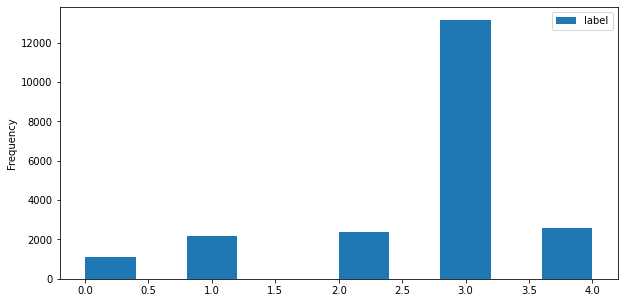

In [ ]:
df.plot.hist(df.label,figsize=(10,5))

In [ ]:
import seaborn as sns

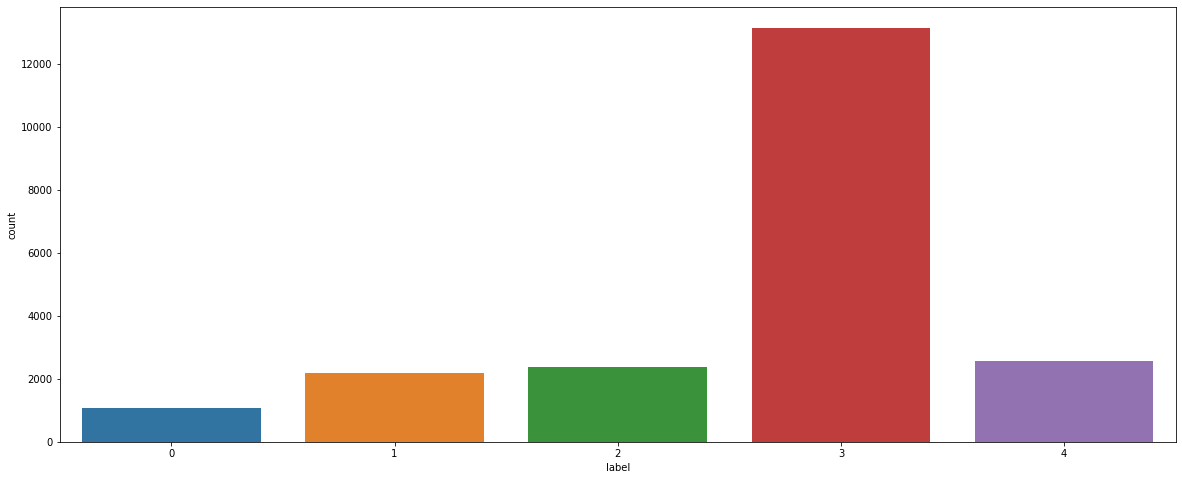

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data=df, x='label')

In [ ]:
import json
with open("/content/label_num_to_disease_map.json") as fn:
    print(json.loads(fn.read()))

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [ ]:
print(len(df))

21397


In [ ]:
img = Image.open(df['path'][1])
w,b = img.size
print(w,b)

800 600


In [ ]:
# Split dataset
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split( df, test_size =0.15, random_state = 42, stratify=df.label.values)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [ ]:
print(len(df_valid))

3210


### Create custom datasets for cassava

In [ ]:
# Data Augumentation
class ImageTransform():
    def __init__(self, input_size):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                    transforms.Resize(input_size),
                    transforms.CenterCrop(input_size),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [ ]:
classes = ['Cassava Bacterial Blight (CBB)',  'Cassava Brown Streak Disease (CBSD)',  'Cassava Green Mottle (CGM)', 
           'Cassava Mosaic Disease (CMD)', 'Healthy']

In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
print(class_to_idx.items())

dict_items([('Cassava Bacterial Blight (CBB)', 0), ('Cassava Brown Streak Disease (CBSD)', 1), ('Cassava Green Mottle (CGM)', 2), ('Cassava Mosaic Disease (CMD)', 3), ('Healthy', 4)])


In [ ]:
class Cassava(Dataset):
    def __init__(self, img_path, transform=None, phase='train'):
        super(Cassava, self).__init__()
        self.img_path = img_path
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img_file_path = self.img_path.iloc[idx,1]
        img = Image.open(img_file_path)

        img_transformed = self.transform(img, self.phase)
        
        label = self.img_path.iloc[idx, 0]
            
        return img_transformed, label

In [ ]:
# Resize to this size
input_size = 150

In [ ]:
train_ds = Cassava(df_train, transform=ImageTransform(input_size), phase='train')
valid_ds = Cassava(df_valid, transform=ImageTransform(input_size), phase='test')

In [ ]:
train_ds.__len__()

18187

In [ ]:
# Test datasets
index = 0
img, label = train_ds.__getitem__(index)
print(img.size())
print(label)

torch.Size([3, 150, 150])
2


In [ ]:
def show_image_tensor(image_tensor,label):
    print(image_tensor.shape)
    plt.figure(figsize=(10,10))
    plt.title(f'Class: {label}')
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 150, 150])


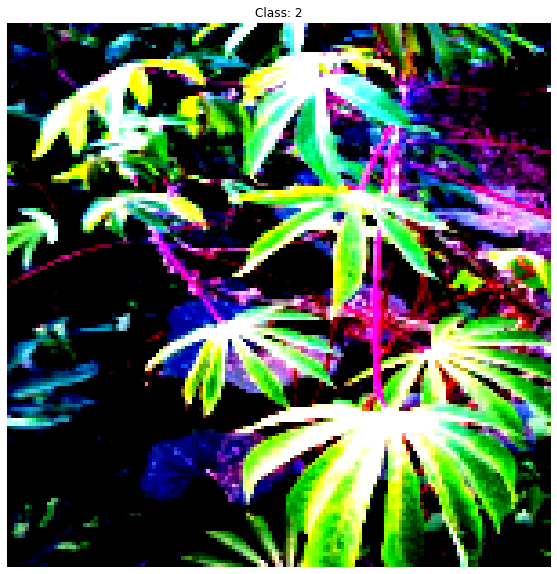

In [ ]:
show_image_tensor(img, label)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_ds, batch_size,shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size, shuffle=False)

dataloader_dict = {"train": train_dataloader, 'test': valid_dataloader}

In [ ]:
batch_iteration = iter(dataloader_dict['train'])
inputs, labels = next(batch_iteration)

In [ ]:
print(inputs.size())
print(labels)

torch.Size([32, 3, 150, 150])
tensor([3, 0, 4, 0, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 1, 1, 3, 3, 1, 3,
        3, 3, 3, 4, 3, 3, 3, 3])


In [ ]:
from torchvision.utils import make_grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


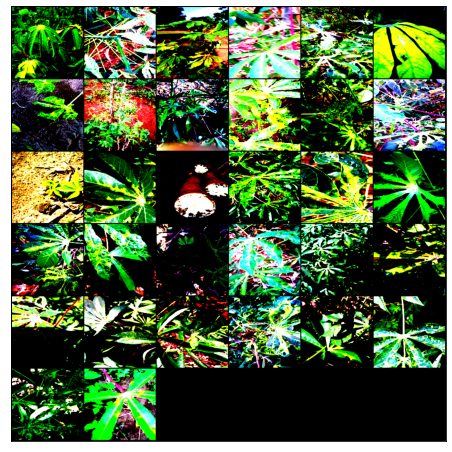

In [ ]:
for img, label in train_dataloader:
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(img, 6).permute(1,2,0))
    break

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
writer = SummaryWriter('runs/vgg16/cassava')

## Training with VGG16

# New Section

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
model = VGG16(n_classes=5).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Validate

In [ ]:
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0

    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)

        # forward pass and record loss
        outputs = model(features)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(data_loader)

    return model, epoch_loss

### Training

In [ ]:
def train_model(model, num_epochs, train_loader,
                valid_loader,optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    valid_loss_min = 1.
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')
                writer.add_scalar("Train_loss/Epoch", loss, epoch)
    
        
        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            _, valid_loss = validate(model, valid_loader, criterion, device=device)
            # Write valid loss to tensorboard
            writer.add_scalar("Valid_loss/Epoch", valid_loss, epoch)
            # Save model
            if valid_loss < valid_loss_min:
                    checkpoint = {'model': model,
                                  'epoch' : epoch+1,
                                  'model_state_dict': model.state_dict(),
                                  'loss': loss,
                                  'optimizer' : optimizer.state_dict()}
                    torch.save(checkpoint, 'model.pth')
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())
            # Write to tensorboard
            writer.add_scalar("Train_acc", train_acc, epoch)
            writer.add_scalar("Valid_acc", valid_acc, epoch)

        writer.flush()
        writer.close()
        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        print("-"*50)
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    # print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

### Compute accuracy

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


### Load checkpoint

In [ ]:
def load_checkpoint(model, optimizer, model_path):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print("Loading checkpoint: {}".format(epoch))
    print("Resume training !!!")
    # Resume training
    model.train()
    return model

In [ ]:
len(dataloader_dict['train'])

569

In [ ]:
NUM_EPOCHS = 20

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=dataloader_dict['train'],
    valid_loader=dataloader_dict['test'],
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/020 | Batch 0000/0569 | Loss: 8.7599
Epoch: 001/020 | Batch 0100/0569 | Loss: 1.5518
Epoch: 001/020 | Batch 0200/0569 | Loss: 1.0832
Epoch: 001/020 | Batch 0300/0569 | Loss: 0.9659
Epoch: 001/020 | Batch 0400/0569 | Loss: 1.1891
Epoch: 001/020 | Batch 0500/0569 | Loss: 1.0490
Epoch: 001/020 | Train: 61.57% | Validation: 61.53%
Time elapsed: 14.07 min
--------------------------------------------------
Epoch: 002/020 | Batch 0000/0569 | Loss: 1.0409
Epoch: 002/020 | Batch 0100/0569 | Loss: 0.8648
Epoch: 002/020 | Batch 0200/0569 | Loss: 1.1533
Epoch: 002/020 | Batch 0300/0569 | Loss: 0.6982
Epoch: 002/020 | Batch 0400/0569 | Loss: 1.1618
Epoch: 002/020 | Batch 0500/0569 | Loss: 1.2864
Epoch: 002/020 | Train: 63.16% | Validation: 64.14%
Time elapsed: 27.70 min
--------------------------------------------------
Epoch: 003/020 | Batch 0000/0569 | Loss: 1.2716
Epoch: 003/020 | Batch 0100/0569 | Loss: 0.9030
Epoch: 003/020 | Batch 0200/0569 | Loss: 0.9761
Epoch: 003/020 | Batch 030

KeyboardInterrupt: ignored

### Show examples

In [ ]:
def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    for batch_idx, (features, targets) in enumerate(data_loader):
        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break
    
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True)
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = features.permute(0, 2, 3, 1)
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)
        
        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
            
    plt.tight_layout()
    plt.show()

### Plot confusion matrix

In [ ]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    return fig, ax

### Compute confusion matrix

In [ ]:
def compute_confusion_matrix(model, data_loader, device):
    all_targets, all_predictions = [], []
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))
            
    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
            
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

### Unnormalized data

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


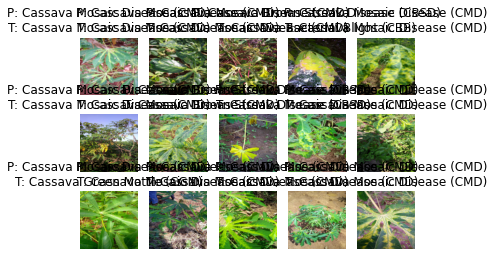

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))


show_examples(model=model, data_loader=dataloader_dict['test'], unnormalizer=unnormalizer, class_dict=idx_to_class)

### Load model

In [ ]:
def load_model(model, model_path):
    print("Loading model")
    load_weights = torch.load(model_path,  map_location={"cuda:0": "cpu"})
    model.load_state_dict(load_weights)
    print("Loading successful!")
    return model

### Predict

In [ ]:
class Predictor():
    def __init__(self, class_index):
        self.class_index = class_index
        
    def predict_max(self, output):
        max_id = np.argmax(output.detach().numpy())
        predicted_label = self.class_index[max_id]
        return predicted_label

In [ ]:
def predict(img):
    model.eval()
    
    # model = load_model(model, 'model.pth')
    

    transform = ImageTransform(input_size)
    img = transform(img, phase="test")
    img = img.unsqueeze(0)
    
    output = model(img)
    response = predictor.predict_max(output)
    
    return response

In [ ]:
predictor = Predictor(classes)

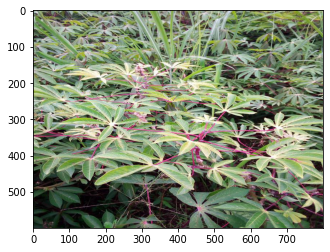

	Predicted image: Cassava Mosaic Disease (CMD)


In [ ]:
test_img = Image.open('test_images/2216849948.jpg').convert('RGB')
plt.imshow(test_img)
plt.show()
print('\tPredicted image:' + " " + predict(test_img))

# Concrete Crack dataset

In [ ]:
!wget -q https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

In [ ]:
!unzip /content/5y9wdsg2zt-2.zip

Archive:  /content/5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [ ]:
!unrar x /content/Concrete\ Crack\ Images\ for\ Classification.rar 

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [ ]:
!rm -rf /content/Concrete

In [ ]:
from pathlib import Path

In [ ]:
!mkdir Concrete
!mv Negative /content/Concrete

In [ ]:
!mv Positive /content/Concrete/

In [ ]:
positive_dir= Path("/content/Concrete/Positive")
negative_dir= Path("/content/Concrete/Negative")

In [ ]:
list(positive_dir.glob(r"*.jpg"))

[PosixPath('/content/Concrete/Positive/17648_1.jpg'),
 PosixPath('/content/Concrete/Positive/09088.jpg'),
 PosixPath('/content/Concrete/Positive/17138_1.jpg'),
 PosixPath('/content/Concrete/Positive/19536.jpg'),
 PosixPath('/content/Concrete/Positive/00451.jpg'),
 PosixPath('/content/Concrete/Positive/13800_1.jpg'),
 PosixPath('/content/Concrete/Positive/12327_1.jpg'),
 PosixPath('/content/Concrete/Positive/13522_1.jpg'),
 PosixPath('/content/Concrete/Positive/03498.jpg'),
 PosixPath('/content/Concrete/Positive/02269.jpg'),
 PosixPath('/content/Concrete/Positive/10836_1.jpg'),
 PosixPath('/content/Concrete/Positive/09017.jpg'),
 PosixPath('/content/Concrete/Positive/01447.jpg'),
 PosixPath('/content/Concrete/Positive/12197_1.jpg'),
 PosixPath('/content/Concrete/Positive/10146_1.jpg'),
 PosixPath('/content/Concrete/Positive/14634_1.jpg'),
 PosixPath('/content/Concrete/Positive/09184.jpg'),
 PosixPath('/content/Concrete/Positive/10239_1.jpg'),
 PosixPath('/content/Concrete/Positive/01060

Text(0.5, 1.0, 'Negative and Positive')

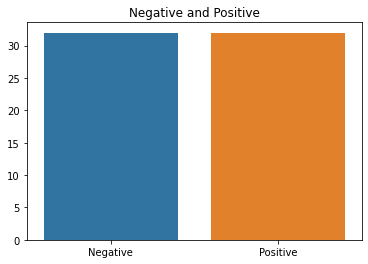

In [ ]:
import seaborn as sns

sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [ ]:
def DataFrame_create(image_dir,label):
    filepaths=pd.Series(list(image_dir.glob(r"*.jpg")),name="Filepath").astype(str)
    labels=pd.Series(label,name="label",index=filepaths.index)
    dataframe=pd.concat([filepaths,labels],axis=1)
    
    return dataframe

In [ ]:
positive_df=DataFrame_create(positive_dir,label="Positive")
negative_df=DataFrame_create(negative_dir,label="Negative")

In [ ]:
df = pd.concat([positive_df,negative_df],axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df.head()

,Filepath,label
0,/content/Concrete/Positive/02954.jpg,Positive
1,/content/Concrete/Positive/19407.jpg,Positive
2,/content/Concrete/Positive/10171_1.jpg,Positive
3,/content/Concrete/Negative/06010.jpg,Negative
4,/content/Concrete/Positive/19908.jpg,Positive


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df , test_df = train_test_split(df, test_size=0.2,shuffle=True,random_state=42)

In [ ]:
train_df.head()

,Filepath,label
14307,/content/Concrete/Positive/06679.jpg,Positive
17812,/content/Concrete/Negative/02037.jpg,Negative
11020,/content/Concrete/Positive/06358.jpg,Positive
15158,/content/Concrete/Positive/18036_1.jpg,Positive
24990,/content/Concrete/Positive/11301_1.jpg,Positive


## Custom datast for Concrete 

In [ ]:
# class ConcreteCrack(Dataset):
#     def __init__(self, root_dir, transform=None, phase='train'):
#         self.list_images_path = []
#         self.list_labels = []
#         self.one_hot_label = {"Negative": 0, "Positive": 1}
#         for sub_dir in os.listdir(root_dir):
#             path_sub_dir = os.path.join(root_dir, sub_dir)
#         for image_name in os.listdir(path_sub_dir):
#             image_path = os.path.join(path_sub_dir, image_name)
#             label = sub_dir
#             self.list_images_path.append(image_path)
#             self.list_labels.append(label)
#         self.phase = phase
#         self.transform = transform

#     def __len__(self):
#         return len(self.list_images_path)

#     def __getitem__(self, idx):
#         image = Image.open(self.list_images_path[idx])
#         img_transformed = self.transform(image, self.phase)

#         label = self.one_hot_label[self.list_labels[idx]]

#         return img_transformed, label

In [ ]:
train_df.iloc[2,1]

'Positive'

In [ ]:
class Concrete(Dataset):
    def __init__(self, img_path, transform=None, phase='train'):
        super(Concrete, self).__init__()
        self.img_path = img_path
        self.one_hot_label = {"Negative": 0, "Positive": 1}
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img_file_path = self.img_path.iloc[idx,0]
        img = Image.open(img_file_path)

        img_transformed = self.transform(img, self.phase)
        
        label = self.img_path.iloc[idx, 1]
        label = self.one_hot_label[self.img_path.iloc[idx, 1]]
            
        return img_transformed, label

In [ ]:
train_dir = "/content/Concrete"


#### Show image in train

In [ ]:
img = os.listdir(os.path.join(train_dir, 'Positive/'))


In [ ]:
import matplotlib.image as mpimg

def show_img(img_list, nrows, ncols, type_):
    fig = plt.figure(figsize=(8,8))
    for i, img_path in enumerate(img_list):
        img = mpimg.imread(os.path.join(train_dir, type_) + img_path)
        fig.add_subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

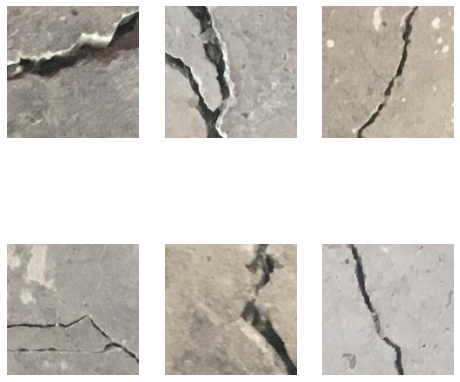

In [ ]:
show_img(img[:6], 2, 3, 'Positive/')

In [ ]:
import cv2

In [ ]:
img = cv2.imread("/content/Concrete/train/Positive/00003.jpg")
print(img.shape)

(227, 227, 3)


#### Test custom dataset

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
writer = SummaryWriter('runs/vgg16/cracks/')

In [ ]:
INPUT_SIZE = 224

In [ ]:
train_ds = Concrete(train_df, transform=ImageTransform(INPUT_SIZE), phase='train')
test_ds = Concrete(test_df, transform=ImageTransform(INPUT_SIZE), phase='test')

In [ ]:
train_ds.__len__()

32000

In [ ]:
img, label = train_ds.__getitem__(1)
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


In [ ]:
train_data_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
batch_iteration = iter(train_data_loader)
inputs, labels = next(batch_iteration)

print(inputs.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1])


In [ ]:
import torchvision

In [ ]:
def imshow(img):
    # img = img * std + mean     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


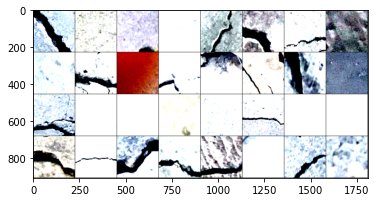

In [ ]:
imshow(torchvision.utils.make_grid(inputs))

### Training with VGG16

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
model = VGG16(n_classes=1)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

RuntimeError: ignored

In [ ]:
NUM_EPOCHS = 20
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_data_loader,
    valid_loader=test_data_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=500)

RuntimeError: ignored